In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath("../../src"))
sys.path.append(os.path.abspath("../../"))
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from pdf_utils.chains import (
    PDFLoaderChain, 
    PreprocessingChain,
    ImageLoaderChain,
    VisionAnalysisChain
)
from config.navigator import Navigator
from textwrap import dedent
from pprint import pprint

/tmp/ipykernel_41439/4163000129.py:1: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from pdf_utils.chains import (


In [3]:
import pdf2image

nav = Navigator()
file = nav.find_file_by_substr(
    "ЯиП_Энергетический_переход_Вызовы_и_возможности", 
    base_dir=nav.raw / "weird-slides",
    # extension=".pdf"
    )[0]
file.name

'ЯиП_Энергетический_переход_Вызовы_и_возможности_для_России_slides-5-6-16-24-26.pdf'

In [4]:
import pdf2image

dpi_list = [
    72, # 1080p - original, no scale
    48, # 720p
    36, # 540
    24, # 360
    16  # 240
] 
images = {dpi: pdf2image.convert_from_path(file, dpi=dpi) for dpi in dpi_list}
pprint(images)

{16: [<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=214x120 at 0x7C8CDF5714B0>,
      <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=214x120 at 0x7C8CDF5716C0>,
      <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=214x120 at 0x7C8CDF571CC0>,
      <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=214x120 at 0x7C8CDF571D20>,
      <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=214x120 at 0x7C8CDF572200>],
 24: [<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=320x180 at 0x7C8CDF571720>,
      <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=320x180 at 0x7C8CDF571F30>,
      <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=320x180 at 0x7C8CDF571D50>,
      <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=320x180 at 0x7C8CDF5721A0>,
      <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=320x180 at 0x7C8CDF571EA0>],
 36: [<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=480x270 at 0x7C8CDF5718A0>,
      <PIL.PpmImagePlugin.PpmImageFile im

In [5]:
images[16][0].tobytes()

b'\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x

In [6]:
from PIL import Image
import base64
import io

def pil_image_to_base64(pil_image: Image):
    buffered = io.BytesIO()
    pil_image.save(buffered, format="png")
    img_str = base64.b64encode(buffered.getvalue())
    return img_str.decode("utf-8")


In [7]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from IPython.display import Image, display
import os
from operator import itemgetter

api_base = os.environ["VSEGPT_API_BASE"]
api_key = os.environ["VSEGPT_API_KEY"]
model = "vis-openai/gpt-4o"
temperature = 0.0

llm = ChatOpenAI(
    base_url=api_base,
    model=model,
    api_key=api_key,
    temperature=temperature
)

vision_prompt = dedent("""\
Представь, что я ничего не вижу. \
Я пришлю тебе слайд из презентации, а ты опиши его. \
Передай мне содержимое слайда в мельчайших подробностях.
""")

chain = (
    RunnablePassthrough.assign(
        image = itemgetter("pil_image") | RunnableLambda(pil_image_to_base64)
    ) 
    | VisionAnalysisChain(
        llm=llm,
        prompt=vision_prompt
    )
    | itemgetter("analysis")
)

In [8]:
VisionAnalysisChain(
        llm=llm,
        prompt=vision_prompt
    )._prompt

'Представь, что я ничего не вижу. Я пришлю тебе слайд из презентации, а ты опиши его. Передай мне содержимое слайда в мельчайших подробностях.\n'

In [14]:
from textwrap import TextWrapper
from typing import Optional
from functools import  partial
from PIL import Image
import matplotlib.pyplot as plt


text_wrapper = TextWrapper(
    width=90, 
    replace_whitespace=False, 
    break_on_hyphens=False,
    break_long_words=False,
)

def query_and_display(
    pil_image: Image, 
    vision_prompt: Optional[str] = None, 
    wrap_width=90, 
    display_image=True
):
    """
    Shortcut to query model and format output.
    
    Returns output without wrapping 
    """
    if display_image:
        # Create a figure with a fixed size (e.g., 8 inches wide and 6 inches tall)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(pil_image)
        ax.axis('off')
        plt.show()

    text_wrapper.width = wrap_width
    
    out = chain.invoke(dict(
        pil_image=pil_image,
        vision_prompt=vision_prompt
    ))
    print(*text_wrapper.wrap(out), sep="\n")
    return out

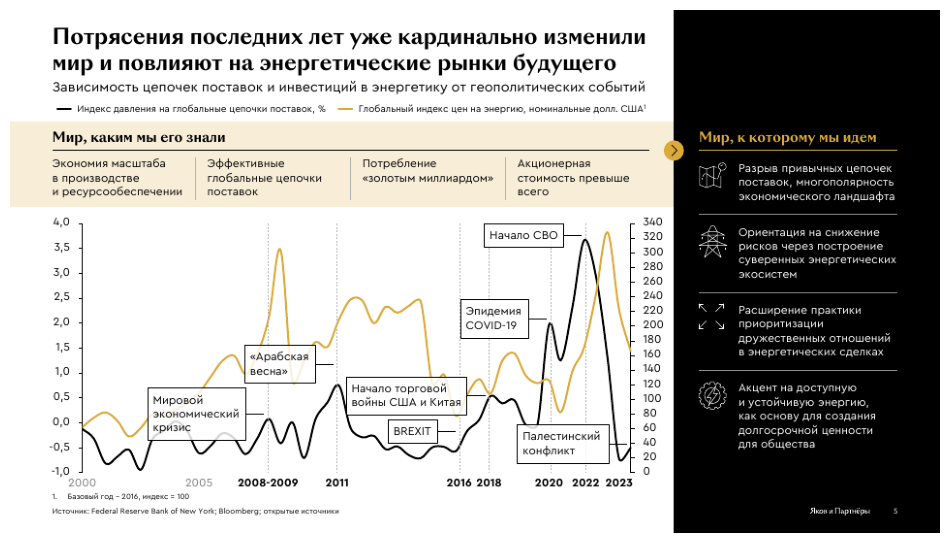

Представь, что я ничего не вижу. Я пришлю тебе слайд из презентации, а ты опиши его. Передай мне содержимое слайда в мельчайших подробностях.

Слайд из презентации содержит следующую информацию:

### Заголовок
- **Потрясения
последних лет уже кардинально изменили мир и повлияют на энергетические рынки будущего**
### Подзаголовок
- **Зависимость цепочек поставок и инвестиций в энергетику от
геополитических событий**

### График
- **Ось Y слева**: Индекс давления на глобальные
цепочки поставок (%)
- **Ось Y справа**: Глобальный индекс цен на энергию (в долларах США)
- **Ось X**: Временная шкала с 2000 по 2023 год

### Ключевые события на графике
-
**Мировой экономический кризис**
- **"Арабская весна" (2008-2009)**
- **BREXIT**
-
**Начало торговой войны США и Китая**
- **Эпидемия COVID-19**
- **Начало СВО**
-
**Палестинский конфликт**

### Легенда
- Черная линия: Индекс давления на глобальные
цепочки поставок
- Золотая линия: Глобальный индекс цен на энергию

### Текстовые блоки
-
**Мир, 

In [15]:
dpi = 72
image = images[dpi][0]
out = query_and_display(image)

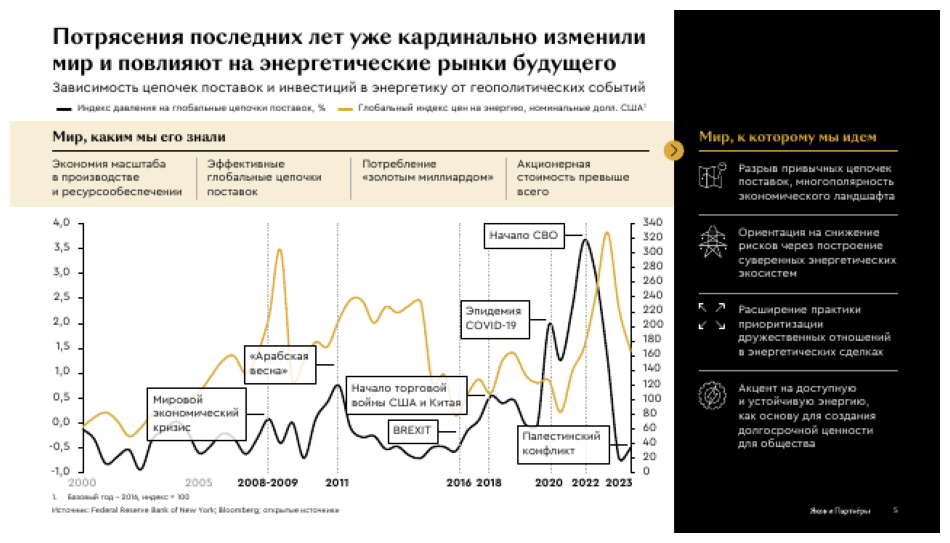

Представь, что я ничего не вижу. Я пришлю тебе слайд из презентации, а ты опиши его. Передай мне содержимое слайда в мельчайших подробностях.

Слайд содержит заголовок и два основных раздела с графиком и списком.

**Заголовок:**
"Потрясения последних лет уже кардинально изменили мир и повлияют на энергетические рынки
будущего."

**Подзаголовок:**
"Зависимость цепочек поставок и инвестиций в энергетику от
геополитических событий."

**График:**
- Две линии: черная и оранжевая.
- Черная линия:
"Индекс давления на глобальные цепочки поставок, %."
- Оранжевая линия: "Глобальный индекс
цен на энергоносители, номинированная долл. США."
- Временной период: 2005-2023 годы.
-
Основные события, отмеченные на графике:
  - Мировой экономический кризис (2008-2009)
  -
Арабская весна (2010-2011)
  - BREXIT (2016)
  - Начало торговой войны США и Китая (2018)
- Эпидемия COVID-19 (2020)
  - Пандемический кризис (2020-2021)
  - Начало СВО (2022)
**Список справа: "Мир, к которому мы идем":**
1. Разрыв при

In [16]:
dpi = 48
image = images[dpi][0]
out = query_and_display(image)

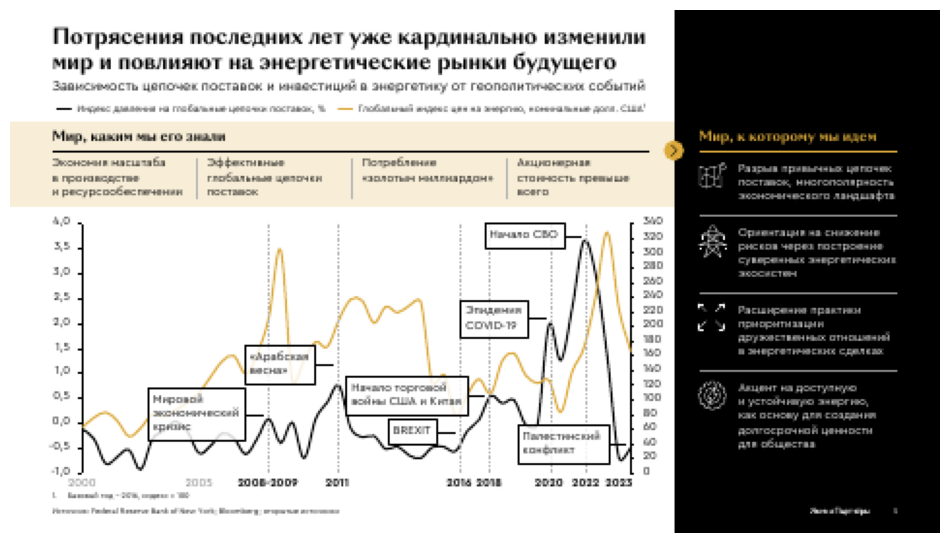

Слайд разделен на две части: левая часть содержит график, а правая — текстовое описание.
**Левая часть:**

Заголовок: "Мир, каким мы его знали"

- График с двумя линиями: черной и
оранжевой.
- Ось Y слева: "Экономика" с показателями от -3,0 до 3,0.
- Ось Y справа: "Цены
на нефть" с показателями от 0 до 200.
- Ось X: временная шкала с 2000 по 2023 год.
-
Черная линия показывает экономические показатели, а оранжевая — цены на нефть.
- На
графике отмечены ключевые события:
  - Неровный экономический рост
  - Арабская весна
  -
Эффективные цепочки поставок
  - Начало торговой войны США и Китая
  - Пандемия COVID-19
- Начало СВО
  - Ажиотаж на рынке газа

**Правая часть:**

Заголовок: "Мир, к которому мы
идем"

- Список с иконками:
  - Устойчивые решения должны повысить надежность поставок,
минимизировать издержки
  - Опережающее развитие возобновляемых источников энергии
  -
Развитие технологий хранения энергии
  - Развитие связанной инфраструктуры
  - Снижение
зависимости от ископаемых ис

In [49]:
dpi = 36
image = images[dpi][0]
out = query_and_display(image)

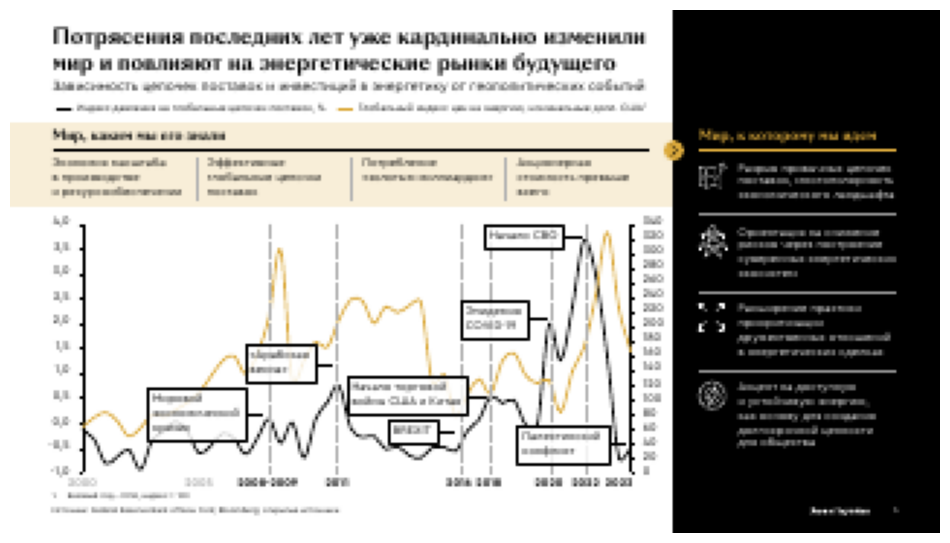

Представь, что я ничего не вижу. Я пришлю тебе слайд из презентации, а ты опиши его. Передай мне содержимое слайда в мельчайших подробностях.

Слайд содержит заголовок и график с пояснениями.

**Заголовок:**
"Потрясения последних лет
уже кардинально изменили мир и повлияют на энергетические рынки будущего."

**График:**
-
На графике изображены две линии: черная и оранжевая.
- Ось Y обозначает цену в долларах
США за баррель.
- Ось X показывает временной промежуток с 2000 по 2023 год.

**Ключевые
моменты на графике:**
1. **2008 год:** Мировой финансовый кризис.
2. **2014 год:** Начало
падения цен на нефть.
3. **2020 год:** Пандемия COVID-19.
4. **2022 год:** Конфликт в
Украине.

**Текстовые блоки:**
- "Мир, к которому мы идем" с перечислением факторов:
  -
Декарбонизация
  - Эффективное использование ресурсов
  - Переход на возобновляемые
источники энергии
  - Цифровизация
  - Новые бизнес-модели

**Справа:**
- Подзаголовок:
"Мир, к которому мы идем"
- Перечислены факторы, влияющие на бу

In [17]:
dpi = 24
image = images[dpi][0]
out = query_and_display(image)

In [20]:
dpi = 24
image = images[dpi][0]
out = query_and_display(
    image, 
    display_image=False,
    vision_prompt=dedent("""\
        Представь, что я ничего не вижу. \
        Я пришлю тебе слайд из презентации, а ты опиши его. \
        Передай мне содержимое слайда в мельчайших подробностях.
                         
        Если слайд плохого качества, попроси прислать изображение лучше.
        """
    )
)

Слайд содержит заголовок и график с пояснениями.

**Заголовок:**
"Потрясения последних лет
уже кардинально изменили мир и повлияют на энергетические рынки будущего."

**График:**
-
На графике изображены две линии: черная и оранжевая.
- Ось Y обозначает цену в долларах
США, а ось X — временной период с 2000 по 2023 год.
- Черная линия показывает изменения
цены на нефть, а оранжевая — на газ.

**Ключевые моменты на графике:**
- 2008: Финансовый
кризис.
- 2014: Падение цен на нефть.
- 2020: Пандемия COVID-19.
- 2022: Энергетический
кризис.

**Текстовые блоки:**
- Слева вверху: "Мир, каким мы его знали" с подзаголовками о
стабильности, доступности энергии и предсказуемости.
- Справа: "Мир, к которому мы идем" с
подзаголовками о новых вызовах, изменениях в энергетике и необходимости адаптации.
**Цветовая схема:**
- Основные цвета: черный, оранжевый и белый.

Если нужно больше
деталей или изображение лучшего качества, дайте знать!


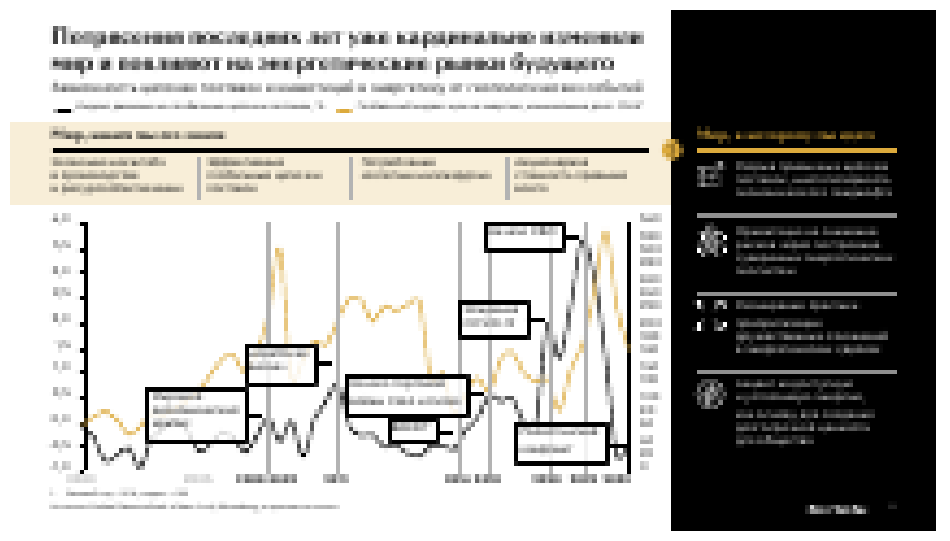

Слайд состоит из двух основных частей: графика и текстового блока.

### Левая часть
(График):
- **Заголовок:** "Подорожание посадок лет уже кардинально изменило мир и
повлияло на энергетические рынки будущего".
- **Подзаголовок:** "Аналитики в один голос
твердят: мир в шаге от энергетического кризиса, который может изменить привычный уклад
жизни".
- **График:** 
  - Две линии: оранжевая и черная, показывающие изменения во
времени.
  - Ось Y: обозначена как "Цена, $/МВтч".
  - Ось X: временная шкала с годами.
- На графике выделены несколько точек с пояснениями в прямоугольниках, указывающих на
важные события или изменения.
  - Примеры пояснений: "Резкий рост цен", "Снижение спроса",
"Введение новых технологий".

### Правая часть (Текстовый блок):
- **Заголовок:** "Мир, в
котором мы живем".
- **Список с иконками:**
  1. **Иконка лампочки:** "Энергетические
кризисы становятся все более частыми".
  2. **Иконка графика:** "Цены на энергию
продолжают расти".
  3. **Иконка глобуса:** "Изменен

In [51]:
dpi = 16
image = images[dpi][0]
out = query_and_display(image)